# Experiment: Comparison to the conventional estimation of 3D LUTs
This Experiment aims to compare the CNN generated 3D LUT to a 3D LUT based on conventional calculations to see the accuracy and speed of AI in the computationally expensive task of estimating LUTs.

For comparison,
we used a dataset of 66 paired images of a Fujifilm X100 F camera. The images were
shot with the film effect Classic Chrome with grain set to weak, the dynamic range set
to DR 400, the white balance set to Daylight R:2 B:-5, highlight tone set to -2, shadow
tone set to +1 and the noise reduction set to 0. We shot in RAW + JPEG setting
and used the RAW images that are unprocessed, without any film emulation, as the
ungraded images, and the JPEG images that are processed with the above-mentioned
film emulation setting, as the graded images.

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
from IPython.display import display
import os
from torchinfo import summary
from pytorch_msssim import ssim, ms_ssim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters

In [3]:
batch_size = 64
lut_size = 33
learning_rate = 1e-4
num_epochs = 200
use_interpolation = True
experiment = "fuji_w_interpolation_03"
model_name = "img2lut_fuji_w_interpolation_03.pth.tar"

# Dataset
The Dataset for this Experiment consists of paired Images that are *ungraded* RAW images and *graded* JPG Images from a Fujifilm X100 F camera.

In [4]:
class PairedImageDataset(Dataset):
    def __init__(self, ungraded_images, graded_images, transform=None):
        self.ungraded_images = ungraded_images
        self.graded_images = graded_images
        self.transform = transform

    def __len__(self):
        return len(self.ungraded_images)

    def __getitem__(self, idx):
        # Returns an ungraded and a graded image
        ungraded = self.ungraded_images[idx]
        graded = self.graded_images[idx]
        if self.transform:
            ungraded = self.transform(ungraded)
            graded = self.transform(graded)
        return ungraded, graded

In [5]:
transform64 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

The function `load_images_from_directory` gets all images that are within a specific directory, converts them into RGB and can apply a transformation to the images. Additionally the number of images that are processed can be limited with the `num_images` parameter. The function returns a tensor of images. The tensor has the shape (number of images x width x height x channels). 

In [7]:
def load_images_from_directory(directory_path, num_images=100, apply_transform=True):
    images = []
    files = os.listdir(directory_path)
    # Ensure only images are processed
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for i, image_file in enumerate(image_files[:num_images]):
        image_path = os.path.join(directory_path, image_file)
        img = Image.open(image_path).convert('RGB')  # Convert to RGB in case of grayscale
        if apply_transform:
            img = transform64(img)  # Apply the transformations

        else:
            img = transform(img)
        images.append(img)
        
    images_tensor = torch.stack(images)
    images_tensor = images_tensor.permute(0, 2, 3, 1)
    return images_tensor

ungraded_images = load_images_from_directory('../../fuji_images/RAW/JPG/256x256', num_images=600)
graded_images = load_images_from_directory('../../fuji_images/JPG/256x256', num_images=600)

# Verify the shape of the tensors
print(ungraded_images.shape)  
print(graded_images.shape)

torch.Size([66, 256, 256, 3])
torch.Size([66, 256, 256, 3])


As we can see above, for this experiment we use 68 images.

In [8]:
ungraded_images_np = ungraded_images.numpy()
graded_images_np = graded_images.numpy()

dataset = PairedImageDataset(ungraded_images_np, graded_images_np, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Visualization of the Dataset

In [9]:
# Function to plot a set of images in a 8x8 grid
def plot_image_grid(images, title):
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(vutils.make_grid(images.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()

## Ungraded training Images
The following Image Grid shows the ungraded training images:

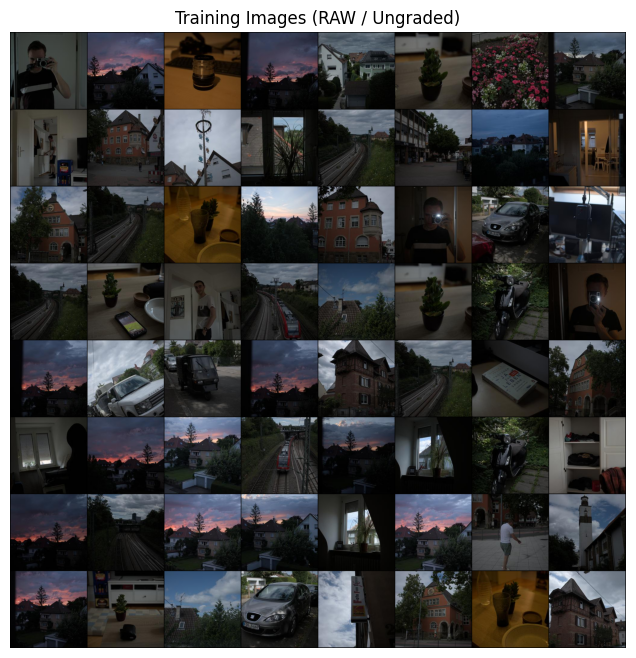

In [10]:
ungraded, graded = next(iter(dataloader))

plot_image_grid(ungraded, "Training Images (RAW / Ungraded)")

## Graded training Images
The following Image Grid shows the graded training images:

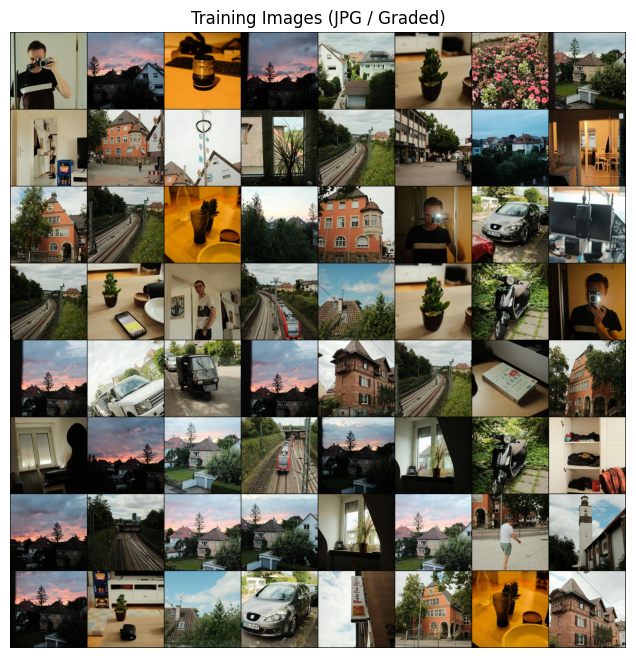

In [11]:
plot_image_grid(graded, "Training Images (JPG / Graded)")

# Apply LUT function

In [12]:
def trilinear_interpolation(luts, images):
    # Scale images to be between -1 and 1
    img = (images - 0.5) * 2.0  # Shape: [4, 3, 256, 256]
    
    # Add a singleton dimension to represent "channel" for LUT interpolation
    img = img.permute(0, 2, 3, 1).unsqueeze(1)  # Shape: [4, 1, 256, 256, 3]

    # Ensure LUT is in the correct format
    LUT = luts.permute(0, 4, 1, 2, 3)  # Shape: [4, 3, 8, 8, 8]

    # Perform grid sampling for each channel
    result = F.grid_sample(LUT, img, mode='bilinear', padding_mode='border', align_corners=True)  # [4, 3, 1, 256, 256]

    # Remove the singleton dimension and permute to the correct format
    result = result.squeeze(2)  # Remove the extra "depth" dimension: [4, 3, 256, 256]

    return result

In [13]:
def simple_approach(luts, images):
    lut = luts.view(luts.shape[0], luts.shape[2], luts.shape[2], luts.shape[2], 3)
    image_normalized = (images * luts.shape[2]-1).long()
    image_normalized = torch.clamp(image_normalized, 0, luts.shape[2]-1)
        
    r = image_normalized[:, 0, :, :]
    g = image_normalized[:, 1, :, :]
    b = image_normalized[:, 2, :, :]
        
    transformed = lut[torch.arange(luts.shape[0]).unsqueeze(-1).unsqueeze(-1), r, g, b]
    transformed = transformed.permute(0, 3, 1, 2)

# ResNet
The model used for this experiment is based on the Residual Network (ResNet) architecture proposed in the paper `Deep Residual Learning for Image Recognition`: https://arxiv.org/pdf/1512.03385

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        return F.relu(out)

Instead of the initial 7x7 convolutional layer, we use a 3x3 filter with a padding of one in the initial convolutional layer that keeps the initial resolution, in this case at 256 x 256. As another measure to adapt the model to lower image resolutions, we use just three residual blocks in comparison to four in the original implementation.
The residual blocks are identical to the ResNet implementation with a filter size of 3x3. Just as mentioned in the paper, "when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2".
In general, convolutional layers are followed by batch normalization and a ReLU activation function as in the original implementation. After the residual blocks, global average pooling is performed, also following the original implementation.
Where the original implementation ends with a 1000-way fully connected layer with a softmax activation function for the task of classifying the 1000 classes in the ImageNet 2012 classification dataset, our model is adopted to generate 3D LUTs. The global average pooling layer is followed by a fully connected layer with 512 dimensions followed by ReLU activation and another fully connected layer that expands the output to the required dimensions for the 3D LUT, which is: LUT_size^3 * channels. The model can be initialized with varying LUT sizes; for an 8 bit LUT the last fully connected layer has 8 * 8 * 8 * 3 = 1536 dimensions.

Source: https://arxiv.org/pdf/1512.03385

In [15]:
class ResNetLUTGenerator(nn.Module):
    def __init__(self, lut_size=8, trilinear=True, input_channels=3):
        super(ResNetLUTGenerator, self).__init__()
        self.lut_size = lut_size
        self.trilinear = trilinear
        if trilinear:
            self.application = self._trilinear_interpolation
        else: 
            self.application = self._simple_approach
        
        # Initial convolution
        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        # ResNet feature extraction
        self.layer1 = self._make_layer(32, 64, stride=2)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # LUT generator
        self.lut_generator = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, lut_size * lut_size * lut_size * 3)
        )

    def _make_layer(self, in_channels, out_channels, stride):
        return ResidualBlock(in_channels, out_channels, stride)


    def _trilinear_interpolation(self,luts, images):
        # Scale images to be between -1 and 1
        img = (images - 0.5) * 2.0  # Shape: [4, 3, 256, 256]
        
        # Add a singleton dimension to represent "channel" for LUT interpolation
        img = img.permute(0, 2, 3, 1).unsqueeze(1)  # Shape: [4, 1, 256, 256, 3]
    
        # Ensure LUT is in the correct format
        LUT = luts.permute(0, 4, 1, 2, 3)  # Shape: [4, 3, 8, 8, 8]
    
        # Perform grid sampling for each channel
        result = F.grid_sample(LUT, img, mode='bilinear', padding_mode='border', align_corners=True)  # [4, 3, 1, 256, 256]
    
        # Remove the singleton dimension and permute to the correct format
        result = result.squeeze(2)  # Remove the extra "depth" dimension: [4, 3, 256, 256]
    
        return result

    def _simple_approach(self, luts, images):
        lut = luts.view(luts.shape[0], luts.shape[2], luts.shape[2], luts.shape[2], 3)
        image_normalized = (images * luts.shape[2]-1).long()
        image_normalized = torch.clamp(image_normalized, 0, luts.shape[2]-1)
            
        r = image_normalized[:, 0, :, :]
        g = image_normalized[:, 1, :, :]
        b = image_normalized[:, 2, :, :]
            
        transformed = lut[torch.arange(luts.shape[0]).unsqueeze(-1).unsqueeze(-1), r, g, b]
        transformed = transformed.permute(0, 3, 1, 2)

        return transformed


    def forward(self, x):
        # Feature extraction
        x_orig = x  # Store original input
        x = self.initial_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        # Global pooling and feature compression
        features = self.global_pool(x).view(x.size(0), -1)
        
        # Generate LUT
        lut = self.lut_generator(features)
        lut = lut.view(-1, self.lut_size, self.lut_size, self.lut_size, 3)
        lut = torch.sigmoid(lut)
        
        # Apply LUT to original input
        transformed = self.application(lut, x_orig)
        return transformed, lut

## Test LUT Generator

In [16]:
sample_input = torch.rand(4, 3, 256, 256).to(device)
LUTGeneratorCNN=ResNetLUTGenerator().to(device)
transformed, lut = LUTGeneratorCNN(sample_input)
print(lut.shape)
print(transformed.shape)

torch.Size([4, 8, 8, 8, 3])
torch.Size([4, 3, 256, 256])


The models architectural summary for 256 x 256 images and an 8 bit LUT is shown in the summary below, where we can see the initial convolutional layer, followed by the three residual blocks, the global average pooling layer and the fully connected layers for the 3D LUT.

In [17]:
test_model = ResNetLUTGenerator()
summary(test_model, input_size=(32, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
ResNetLUTGenerator                       [32, 3, 256, 256]         --
├─Sequential: 1-1                        [32, 32, 256, 256]        --
│    └─Conv2d: 2-1                       [32, 32, 256, 256]        896
│    └─BatchNorm2d: 2-2                  [32, 32, 256, 256]        64
│    └─ReLU: 2-3                         [32, 32, 256, 256]        --
├─ResidualBlock: 1-2                     [32, 64, 128, 128]        --
│    └─Conv2d: 2-4                       [32, 64, 128, 128]        18,496
│    └─BatchNorm2d: 2-5                  [32, 64, 128, 128]        128
│    └─Conv2d: 2-6                       [32, 64, 128, 128]        36,928
│    └─BatchNorm2d: 2-7                  [32, 64, 128, 128]        128
│    └─Sequential: 2-8                   [32, 64, 128, 128]        --
│    │    └─Conv2d: 3-1                  [32, 64, 128, 128]        2,112
│    │    └─BatchNorm2d: 3-2             [32, 64, 128, 128]        128


# Train Function

In [18]:
def display_image(image, width=256):
    tensor_image = image.detach().cpu()
    # Rearrange to HWC format and scale to [0, 255]
    image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))  # Select the first image in batch and permute to HWC
    image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
            
    image = Image.fromarray(image_np)
    display(image)

In [19]:
def display_images(images, titles=None):
    # Three subplots in one row
    fig, axes = plt.subplots(1, 3, figsize=(4, 2))
    
    # Convert and display each image
    for idx, (ax, img) in enumerate(zip(axes, [images[0], images[1], images[2]])):
        # Convert tensor to numpy array
        tensor_image = img.detach().cpu()
        image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))
        image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
        
        # Display the image
        ax.imshow(image_np)
        ax.axis('off')
        
        # Set title if provided
        if titles and idx < len(titles):
            ax.set_title(titles[idx])
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [22]:
def train_model(model, dataloader, optimizer, criterion, num_epochs=10):
    model.train()
    epoch_losses = [] 

    # Create ReduceLROnPlateau scheduler as in the ResNet paper - divides learning rate by 10 when the error plateaus  https://arxiv.org/pdf/1512.03385
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for ungraded, graded in dataloader:
            ungraded, graded = ungraded.to(device), graded.to(device)

            # Forward pass
            optimizer.zero_grad()
            transformed, _ = model(ungraded)

            loss = criterion(transformed, graded) #+ ssim_loss(transformed, graded) #+ calc_lut_loss(lut)

            # Backward pass
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_epoch_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_epoch_loss)

        # scheduler step with average loss
        scheduler.step(avg_epoch_loss)
        
        #print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader)}")
        if epoch % 50 == 0:
            display_images([ungraded[0], graded[0], transformed[0]], ["raw", "jpg", "model output"])

    return epoch_losses

# Training

In [23]:
model = ResNetLUTGenerator(lut_size=lut_size, trilinear=use_interpolation).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

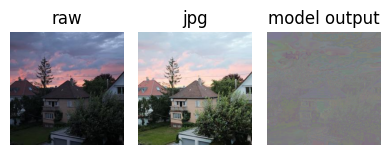

 25%|████████████████████▎                                                            | 50/200 [00:09<00:28,  5.27it/s]

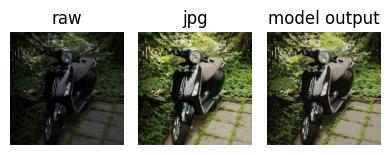

 50%|████████████████████████████████████████                                        | 100/200 [00:19<00:18,  5.32it/s]

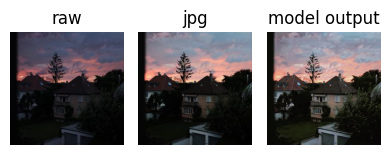

 75%|████████████████████████████████████████████████████████████                    | 150/200 [00:28<00:09,  5.32it/s]

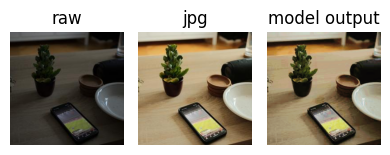

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:37<00:00,  5.27it/s]


In [24]:
loss_summary = train_model(model, dataloader, optimizer, criterion, num_epochs)

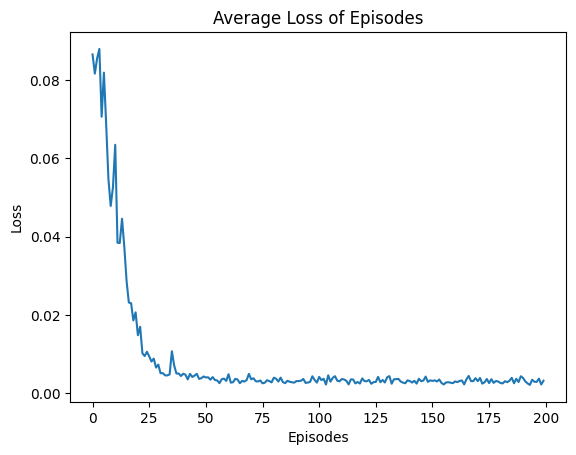

In [25]:
plt.plot(loss_summary)
# Add Title

plt.title("Average Loss of Episodes") 

# Add Axes Labels

plt.xlabel("Episodes") 
plt.ylabel("Loss") 

# Display

plt.show()

As we can see above the loss decreases rapidly in the first 25 episodes and stabilizes after around 70 episodes with slight fluctuation but no further decrease. \
It looks as if our model was trained successfully, which we will test in the evaluation below.

## Save Model

In [26]:
def save_checkpoint(model, optimizer, directory, filename="models/checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    directory = f"models/{directory}"
    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    torch.save(checkpoint, os.path.join(directory, filename))

In [27]:
save_checkpoint(model, optimizer, directory=experiment, filename=model_name)

=> Saving checkpoint


# Evaluation
For the evaluation we compare the performance of our trained model and the LUT calculated by the Darktable LUT generator on the training images. In a next step we are going to test how the model and the calculated LUT perform on a set of test images taken with a Sony camera and compare the smoothness of color transitions by applying the LUTs to full resolution images.

In [28]:
eval_experiment = "fuji_w_interpolation_03"
eval_filepath = "img2lut_fuji_w_interpolation_03.pth.tar"

In [29]:
eval_model = ResNetLUTGenerator(lut_size=lut_size, trilinear=use_interpolation).to(device).to(device)
eval_optimizer = optim.Adam(eval_model.parameters(), lr=learning_rate)

In [30]:
def load_checkpoint(model, optimizer, experiment, filepath):
    
    filepath = f"models/{experiment}/{filepath}"
    print(f"=> Loading checkpoint from {filepath}")
    checkpoint = torch.load(filepath, weights_only=True)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    return model, optimizer

In [31]:
eval_generator, _ = load_checkpoint(eval_model, eval_optimizer, eval_experiment, eval_filepath)

=> Loading checkpoint from models/fuji_w_interpolation_03/img2lut_fuji_w_interpolation_03.pth.tar


### Performance on Training Images

In [32]:
eval_generator.eval()
ungraded = ungraded.to(device)
edited_images, luts = eval_generator(ungraded)

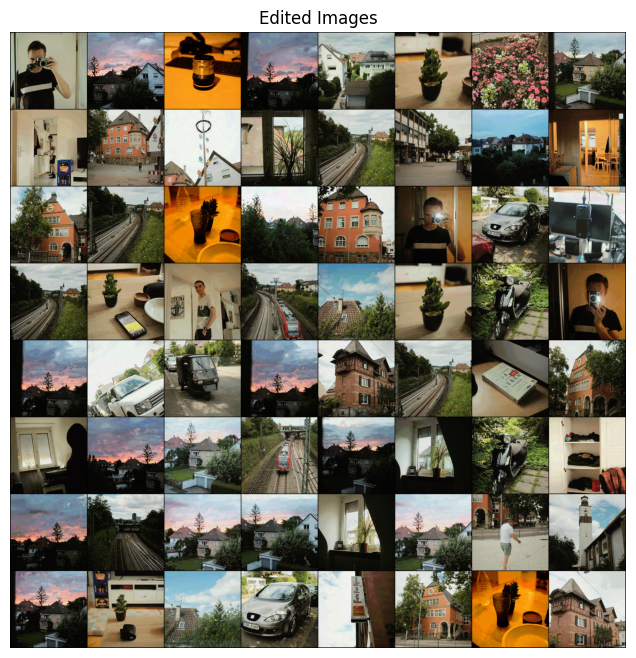

In [33]:
plot_image_grid(edited_images, "Edited Images")

### Is the generated LUT always the same?

In [34]:
luts = []
for i in range(5):
    sample_input = torch.rand(1, 3, 64, 64).to(device)
    _, lut = eval_model(sample_input)
    luts.append(lut)

In [35]:
total_difference = sum(torch.sum(torch.abs(luts[i] - luts[j])) for i in range(len(luts)) for j in range(i + 1, len(luts)))

print(f"Total sum of differences: {total_difference}")

Total sum of differences: 11447.2421875


As we want to know if our model learns an image adaptive 3D LUT we test if the LUT is always the same or not. As we can see above the LUTs generated for five random inputs seem to differ. \
In a next step we are going to generate two LUTs for two images of our image data and apply them on the indented image and the other image.

In [36]:
_, lut0 = eval_model(ungraded[0].unsqueeze(0))
_, lut30 = eval_model(ungraded[30].unsqueeze(0))

In [37]:
image30_lut0 = trilinear_interpolation(lut0, ungraded[30].unsqueeze(0))
image30_lut30 = trilinear_interpolation(lut30, ungraded[30].unsqueeze(0))
image0_lut30 = trilinear_interpolation(lut30, ungraded[0].unsqueeze(0))
image0_lut0 = trilinear_interpolation(lut0, ungraded[0].unsqueeze(0))

In [38]:
def display_images(images):
    # Convert each tensor image to numpy and scale to [0, 255]
    images_np = []
    for image in images:
        tensor_image = image.detach().cpu()
        image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))  # Convert to HWC format
        image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
        images_np.append(image_np)
    
    # Concatenate images horizontally
    combined_image = np.concatenate(images_np, axis=1)
    
    # Create a PIL Image and display it
    combined_pil_image = Image.fromarray(combined_image)
    display(combined_pil_image)

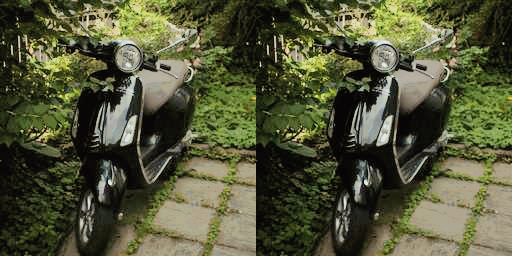

In [39]:
display_images([image30_lut0[0], image30_lut30[0]])

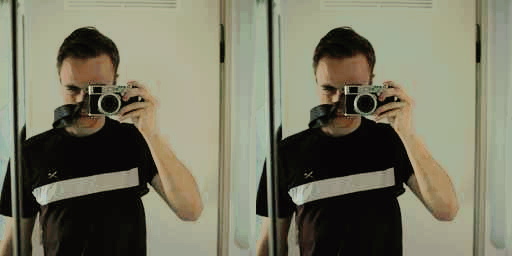

In [40]:
display_images([image0_lut0[0], image0_lut30[0]])

As we can see above the generated LUTs are slightly different which is especially visible in the skin colors of the second pair of edited images.

# Save LUT
To test a generated LUT in other image editing tools such as Photoshop or Lightroom we created the function `save_lut_from_model`.

In [41]:
def save_lut_from_model(model, sample_input, filename="trained_lut.cube", title="Generated LUT"):
    """
    Saves a 3D LUT generated by the model to a .cube file.
    
    Parameters:
        model (torch.nn.Module): Trained LUT generation model.
        sample_input (torch.Tensor): A sample input to generate the LUT. Shape: (B, C, H, W).
        filename (str): The output .cube file name.
        title (str): Title for the LUT.
    """
    import numpy as np
    import torch

    # Ensure model is in evaluation mode
    model.eval()

    # Generate the LUT
    with torch.no_grad():
        _, lut = model(sample_input)  # Forward pass
        lut_size = lut.shape[2]
        lut = lut.view(lut_size, lut_size, lut_size, 3)  # Reshape to (8, 8, 8, 3)

    # Ensure LUT is in numpy format
    lut = lut.detach().cpu().numpy()

    # Save the LUT to .cube
    with open(filename, "w") as f:
        # Write the header
        f.write(f"TITLE \"{title}\"\n")
        f.write(f"LUT_3D_SIZE {lut_size}\n")
        f.write("\n")

        # Normalize LUT values to [0, 1]
        lut = np.clip(lut, 0, 1)

        # Write LUT values
        for z in range(lut_size):
            for y in range(lut_size):
                for x in range(lut_size):
                    r, g, b = lut[x, y, z]  # Cube indexing convention
                    f.write(f"{r:.8f} {g:.8f} {b:.8f}\n")

    print(f"LUT saved to {filename}")

In [42]:
save_lut_from_model(eval_model, ungraded[0].unsqueeze(0), filename="trained_fuji_lut_w_interpolation.cube", title="Trained Fuji LUT")

LUT saved to trained_fuji_lut_w_interpolation.cube


# Test LUT
Now that we have edited the training images with our model it is time to edit them with the calculated LUT as well to compare their performance. \
Therefore we created the function `load_cube_lut` to load the calculated 3D LUTs from the `.cube` file. \
We apply the LUT with the function `trilinear_interpolation` that we defined earlier to our training images.

In [45]:
def load_cube_lut(lut_path):
    """
    Loads a .cube LUT file and returns it as a 3D numpy array.
    """
    with open(lut_path, 'r') as file:
        lines = file.readlines()

    # Read the LUT size (usually a 3D grid, e.g., 33x33x33)
    lut_size = None
    for line in lines:
        if line.lower().startswith('lut_3d_size'):
            lut_size = int(line.split()[1])
            break
    
    if not lut_size:
        raise ValueError("LUT size not found in the .cube file.")
    
    # Parse LUT data (expecting RGB values)
    lut = []
    for line in lines:
        if line.startswith("0") or line.startswith("1"):
            # Parsing LUT values (RGB)
            values = list(map(float, line.split()))
            lut.append(values)
    
    # Convert to a numpy array
    lut = np.array(lut).reshape((lut_size, lut_size, lut_size, 3))
    return lut, lut_size

### Comparison of LUT vs Model

#### Visual Comparison
We load a specific image from our training data to compare the editing with the generated and calculated 3D LUT.

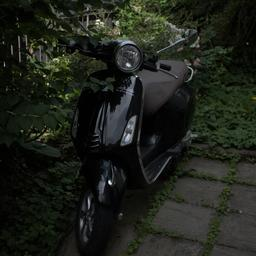

In [46]:
image = Image.open('../../fuji_images/RAW/JPG/256x256/DSCF2582.JPG')
display(image)

In [47]:
lut, lut_size = load_cube_lut("../../fuji_images/Fuji01.cube")

In [48]:
tensor = torch.from_numpy(lut)
# Add a new dimension at the start
tensor_lut = tensor.unsqueeze(0).to(device) 

In [49]:
sample_image = transform(image).unsqueeze(0)
sample_image = sample_image.to(device)

In [50]:
tensor_lut.shape

torch.Size([1, 9, 9, 9, 3])

In [51]:
sample_image.shape

torch.Size([1, 3, 256, 256])

In [52]:
edited_image_lut = trilinear_interpolation(tensor_lut.float(), sample_image.float())

In [53]:
edited_image_model, lut = eval_model(sample_image)

In [54]:
jpg_image = Image.open('../../fuji_images/JPG/256x256/DSCF2582.JPG')
jpg_image = transform(jpg_image)
jpg_image = jpg_image.to(device)

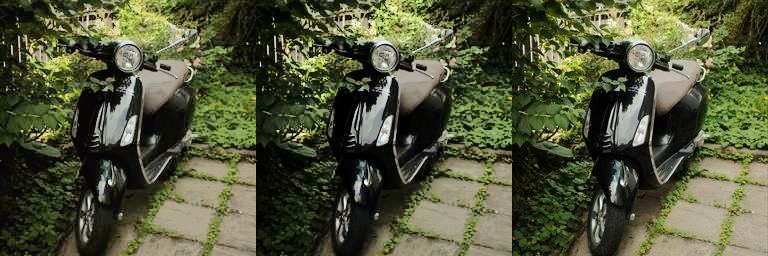

In [55]:
display_images([edited_image_model[0], edited_image_lut[0],jpg_image])

As we can see above the image edited by our model manages to match the green tones of the target JPG image on the left, while the image edited with the calculated LUT in the middle appear to have slightly cooler colors.

#### Get all Images with LUT
In the next step we edit all 64 images we use for comparison with the calculated LUT. 

In [56]:
tensor_lut_batch = tensor_lut.repeat(64, 1, 1, 1, 1)

In [57]:
edited_images_lut = trilinear_interpolation(tensor_lut_batch.float(), ungraded.float())

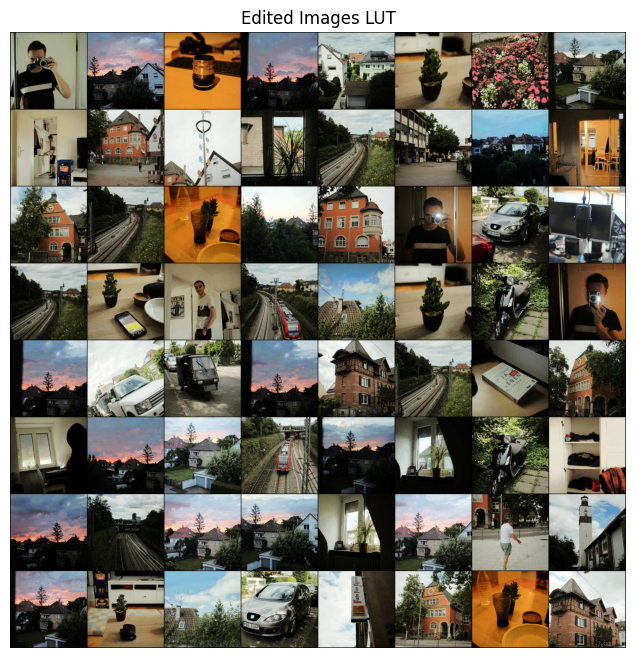

In [58]:
plot_image_grid(edited_images_lut, "Edited Images LUT")

#### Calculate MSE between target Images (Graded JPG) and the two sets of edited images (Model and calculated LUT)
To have an accurate measurement of how the two approaches compare we calculate the MSE between the two sets of edited images and the target JPG images.

In [59]:
def calc_mse(images1, images2):
    mse = torch.mean((images1 - images2) ** 2)
    return mse

In [60]:
mse_edited_lut = calc_mse(edited_images_lut, graded.to(device))

In [61]:
mse_edited_model = calc_mse(edited_images, graded.to(device))

In [62]:
print(mse_edited_lut)

tensor(0.0042, device='cuda:0')


In [63]:
print(mse_edited_model)

tensor(0.0031, device='cuda:0', grad_fn=<MeanBackward0>)


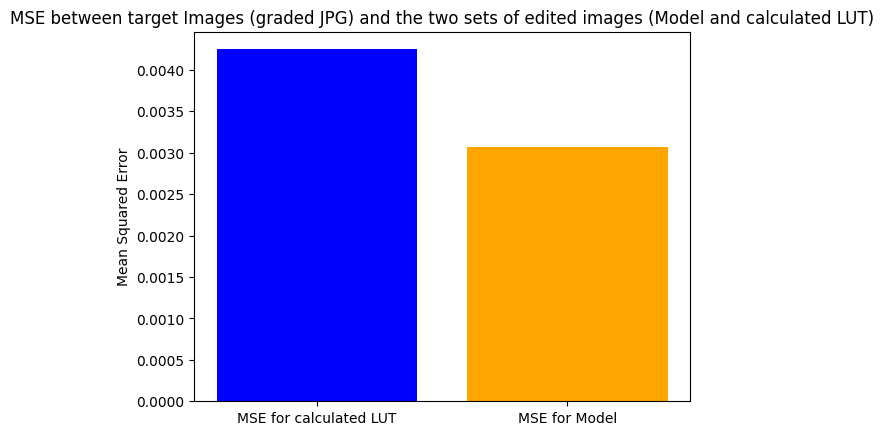

In [64]:
labels = ['MSE for calculated LUT', 'MSE for Model']
values = [mse_edited_lut.cpu().item(), mse_edited_model.cpu().item()]

plt.bar(labels, values, color=['blue', 'orange'])

# Add labels and title
plt.ylabel('Mean Squared Error')
plt.title('MSE between target Images (graded JPG) and the two sets of edited images (Model and calculated LUT)')

plt.show()

As we can see above, the MSE confirms what we have seen earlier. Our model achieves a MSE of just 0.0031 in comparison to the calculated LUTs MSE of 0.0042.

#### Performance on Sony images

In [78]:
class ValDataset(Dataset):
    def __init__(self, val_images, transform=None):
        self.val_images = val_images
        self.transform = transform

    def __len__(self):
        return len(self.val_images)

    def __getitem__(self, idx):
        val_image = self.val_images[idx]
        if self.transform:
            val_image = self.transform(val_image)
        return val_image

In [79]:
def load_orig_images(directory, num_images):
    images = []
    files = os.listdir(directory)
    
    # Ensure only image files are processed
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for i, image_file in enumerate(image_files[:num_images]):
        image_path = os.path.join(directory, image_file)
        img = Image.open(image_path).convert('RGB')
        img = transform(img).unsqueeze(0)
        img = img.to(device)
        images.append(img)

    return images

In [ ]:
sony_images = load_orig_images('../../sony_images/Validation', num_images=64)

In [ ]:
sony_images_256 = load_images_from_directory('../../sony_images/Validation', num_images=64)

In [ ]:
sony_dataset = ValDataset(sony_images_256.numpy(), transform)
sony_dataloader = DataLoader(sony_dataset, batch_size=batch_size, shuffle=True)

In [81]:
sony_val_images = next(iter(sony_dataloader))
sony_val_images = sony_val_images.to(device)

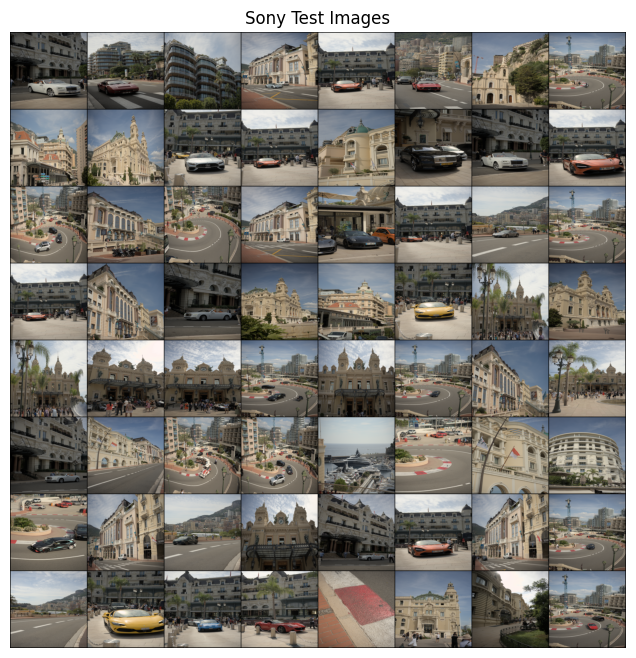

In [82]:
plot_image_grid(sony_val_images, "Sony Test Images")

In [83]:
def save_image(image, output_dir, filename):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    tensor_image = image.detach().cpu()
    # Rearrange to HWC format and scale to [0, 255]
    image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))  # Select the first image in batch and permute to HWC
    image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
            
    img = Image.fromarray(image_np)
    img = img.convert('RGB')
    img.save(os.path.join(output_dir, filename))

In [ ]:
for i,sony_img in tqdm(enumerate(sony_images), total=len(sony_images)):
    test = trilinear_interpolation(tensor_lut, sony_img)
    save_image(test[0], "test_images", f"test_lut{i}.jpg")

In [ ]:
for i,sony_img in tqdm(enumerate(sony_images), total=len(sony_images)):
    test = trilinear_interpolation(eval_model(sony_val_images[i].unsqueeze(0))[1], sony_img)
    save_image(test[0], "test_images", f"test_model{i}.jpg")

In [ ]:
edited_images_lut = trilinear_interpolation(tensor_lut_batch, sony_val_images.to(device))

In [ ]:
edited_images_model, luts = eval_model(sony_val_images.to(device))

In [ ]:
plot_image_grid(edited_images_lut, "Edited Images with calculated LUT")

In [ ]:
plot_image_grid(edited_images_model, "Edited Images with Model")

# Conclusion
The training took just 39 seconds. In comparison to that the conventional calculation
with the darktable LUT generator took 13 minutes and 55 seconds. The MSE on the
training images was 0.0031 for the model and 0.0042 for the conventionally calculated
LUT. In addition to that, we compared the edited Sony images side by side to compare the
smoothness of color transitions and search for unwanted artifacts. In general, the color
transitions seem to be smoother with the images edited by our model, further information on that can be found in our paper.
As the training time of the model was drastically shorter than the time taken for the
conventional calculation and the model outperforms the conventionally calculated LUT
on both the MSE on the training images and on the visual comparison based on test
images, we can conclude that it is not only possible to calculate 3D LUTs with CNNs,
but is also, according to these results, the preferable method.